<a href="https://colab.research.google.com/github/alysawyer/p-recipe/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the code created to train the model, primarily worked on by Jack Susank and Bengisu Bulur.

Run this code when using the TPU

In [ ]:
!pip install torch_xla

import torch_xla.core.xla_model


print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)



if "COLAB_TPU_ADDR" in os.environ:
    device = torch.device("xla:1")  # Use TPU

print(device)


!echo $COLAB_TPU_ADDR

%env XRT_TPU_CONFIG="localservice;0;worker:0;grpc://localhost:8470"

import torch_xla.core.xla_model as xm

device = xm.xla_device()

os.environ["XRT_TPU_CONFIG"] = "localservice;0;worker:0;10.68.172.10:8470"


Run this code when using the GPU T4

In [ ]:
import torch

# Check if GPU is available
print(torch.cuda.is_available())

# Get the GPU device name
print(torch.cuda.get_device_name(0))


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

True
Tesla T4
cuda


Imports your Google Drive!


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Imports Libraries

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import time
import copy
from PIL import Image
# import splitfolders

import locale

# Set the locale to en_US
#locale.setlocale(locale.LC_ALL, 'en_US')


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

Experimenting with TPU and device setup

These are the names of the new data_set

In [ ]:
new_labels = ["apples", "aubergine", "avocado", "bananas", "beans", "blueberries", "bread", "broccoli", "butter", "cake mix", "carrots", "cheese", "cherry", "chicken", "coffee", "corn", "eggs", "flour", "ginger", "green beans", "green chilies", "ham", "honey", "jam", "juice", "kiwi", "lemon", "lettuce", "lime", "mango", "milk", "mushrooms", "nuts", "oil", "onion", "orange", "pasta", "peach", "peas", "peppers", "pineapple", "potato", "rice", "spices", "spinach", "strawberry", "sugar", "sweet potato", "tea", "tomato sauce", "tomatoes", "tuna", "vinegar", "water", "watermelon", "yogurt", "zuccini"]

In [ ]:
# This is an old list of all the possible types of labels.
old_names = ["Lemon", 'Onion', 'Orange', 'Peas', 'Potato', 'Strawberry', 'Tomato', 'apples', 'aubergine', 'bananas', 'blueberries', 'bread', 'broccoli', 'butter', 'carrots', 'cheese', 'chicken', 'courgettes', 'eggs', 'ginger', 'green beans', 'green chilies', 'ham', 'lemon', 'lettuce', 'lime', 'milk', 'mushrooms', 'onion', 'orange', 'peach', 'peppers', 'red onion', 'spinach', 'spring onion', 'strawberries', 'sweet_potato', 'tomatoes', 'yoghurt', 'JUICE', 'NUTS', 'BEANS', 'CAKE_MIX', 'JAM', 'COFFEE', 'OIL', 'VINEGAR', 'TUNA', 'FLOUR', 'HONEY', 'TEA', 'WATER', 'TOMATO_SAUCE', 'CORN', 'PASTA', 'RICE', 'SUGAR', 'SPICES', 'avocado', 'cherry', 'kiwi', 'watermelon', 'pineapple']

Setting up the model (Resnet18)

In [ ]:
# Working with the model! Resnet 18
model = models.resnet18(pretrained=True)
model
# print(model)

num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)

# ended at sugar before (57)
model.fc = nn.Linear(num_features, 57)
model = model.to(device)

requires_grad=False

Number of features from pre-trained model 512


Transforming the dataset

In [ ]:
train_dir = "/content/gdrive/MyDrive/Jacks_Data_Train"
test_dir = "/content/gdrive/MyDrive/Jacks_Data_Test"

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Training the model!

Streaming output truncated to the last 5000 lines.
Finished input 459
Finished input 460
Finished input 461
Finished input 462
Finished input 463
Finished input 464
Finished input 465
Finished input 466
Finished input 467
Finished input 468
Finished input 469
Finished input 470
Finished input 471
Finished input 472
Finished input 473
Finished input 474
Finished input 475
Finished input 476
Finished input 477
Finished input 478
Finished input 479
Finished input 480
Finished input 481
Finished input 482
Finished input 483
Finished input 484
Finished input 485
Finished input 486
Finished input 487
Finished input 488
Finished input 489
Finished input 490
Finished input 491
Finished input 492
Finished input 493
Finished input 494
Finished input 495
Finished input 496
Finished input 497
Finished input 498
Finished input 499
Finished input 500
Finished input 501
Finished input 502
Finished input 503
Finished input 504
Finished input 505
Finished input 506
Finished input 507
Finished input 508

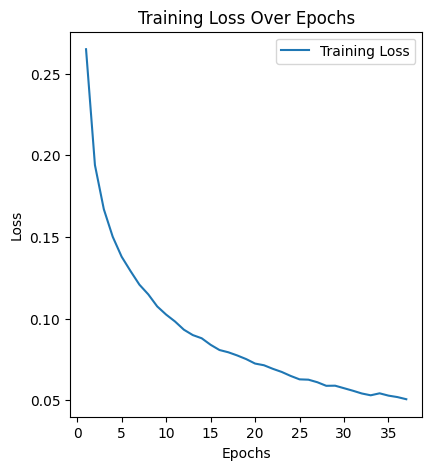

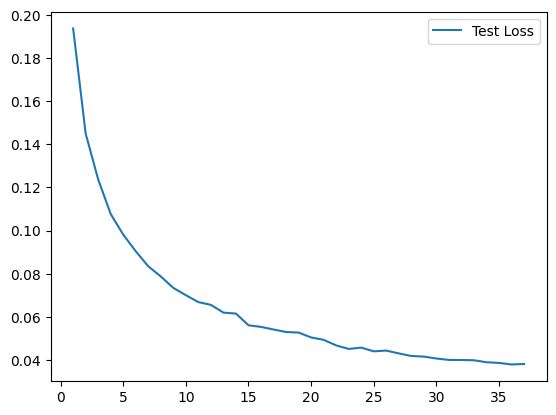

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]


num_epochs = 37   #(set no of epochs)
start_time = time.time() #(for showing time)

# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)

    """ Training Phase """

    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):

        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        print("Finished input " + str(i))
    print("Done with step 2")
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))


    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))





    checkpoint_interval = 3

    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = f'/content/gdrive/MyDrive/Model/12-4-23_training_versions/checkpoint_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), checkpoint_path)


# Plot Training Loss
if train_loss:
    plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss')
    plt.legend()
    plt.show()
else:
    print("No data to plot.")



# Plot Test Loss
if test_loss:
    plt.plot(range(1, num_epochs + 1), test_loss, label='Test Loss')
    plt.legend()
    plt.show()
else:
    print("No data to plot.")


Loading the epoch 15 model

In [ ]:
import torch
import torchvision.models as models

# Example: Loading a pre-trained ResNet model
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Model/12-4-23_training_versions/checkpoint_epoch_15.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Testing the epoch 15 model on the test data

In [ ]:
running_corrects = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        running_corrects += torch.sum(predicted == labels.data).item()

test_accuracy = running_corrects / total
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 80.19%


In [ ]:
correct_labels = ["BEANS", "CAKE_MIX", "COFFEE", "CORN", "FLOUR", "HONEY", "JAM", "JUICE", "Lemon", "NUTS", "OIL", "Onion", "Orange", "PASTA", "Peas", "Potato", "RICE", "SPICES", "SUGAR", "Strawberry", "TEA", "TOMATO_SAUCE", "TUNA", "VINEGAR", "WATER","Zucchini", "apples", "aubergine", "avocado", "bananas", "blueberries", "bread", "broccoli", "butter", "carrots", "cheese", "cherry", "chicken", "eggs", "ginger", "green beans", "green chilies", "ham", "kiwi", "lettuce", "lime", "mango", "milk", "mushrooms", "peach", "peppers", "pineapple", "spinach", "sweet_potato", "tomatoes", "watermelon", "yoghurt"]
print(len(correct_labels))

print(correct_labels[26])


57
apples
